# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use directly [the app](https://www.craiyon.com/).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [ ]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 180 kB 6.5 MB/s 
     |████████████████████████████████| 197 kB 50.3 MB/s 
     |████████████████████████████████| 235 kB 69.2 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 4.7 MB 69.8 MB/s 
     |████████████████████████████████| 1.8 MB 61.7 MB/s 
     |████████████████████████████████| 217 kB 81.9 MB/s 
     |████████████████████████████████| 145 kB 92.6 MB/s 
     |████████████████████████████████| 1.1 MB 71.2 MB/s 
     |████████████████████████████████| 51 kB 8.1 MB/s 
     |████████████████████████████████| 76 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 51.2 MB/s 
     |████████████████████████████████| 120 kB 78.3 MB/s 
     |████████████████████████████████| 157 kB 73.2 MB/s 
     |████████████████████████████████| 181 kB 76.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 73.3 MB/s 
     |█████████████████

We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [ ]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [ ]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [ ]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:1:17.9
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmplhb1jqk4:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBart

Model parameters are replicated on each device for faster inference.

In [ ]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [ ]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt using Facebook BART summarizer

Our model requires processing prompts.

In [ ]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:37.9


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

In [ ]:
#installing the transformers library
%pip install transformers

**Let**'s define some text prompts.

In [ ]:
from transformers import pipeline

In [ ]:
article= [r'The Amazon rainforest, the largest rainforest on Earth, encompasses an area roughly the size of the United States (the 48 contiguous states), contains most of the plant and animal species found on the planet and contributes to weather patterns on a global scale. This natural wonder is disappearing at an alarming rate due to deforestation and with it the animals, plants and eventually humans will disappear as well. This applies to all plants, animals and humans, not just those who inhabit this region of South America. If the Amazon rainforest disappears, the entire human race will likely suffer the same fate resulting from the climatic changes that would result. This disturbing scenario has been well documented by environmental organizations, governmental studies, independent agency reviews and scientific journals spanning the past three decades from which this discussion will draw. The Amazon rainforest represents close to half of the world’s rainforest regions. Estimates of its size vary but the general consensus is that the Amazon rainforest covers approximately seven million square kilometers. It represents 40 per cent of the South American continent encroaching on nine of its countries including Brazil, Suriname, Bolivia, Guyana, French Guyana, Ecuador, Peru, Colombia and Venezuela. The greatest portion (62 per cent) lies within the boundaries of Brazil. This massive area, if a single country, would rank sixth largest in the world and is at least half the size of the entire European continent. The seemingly boundless rainforest is shrinking at a rapid pace due to deforestation, however, which will soon result in grave consequences for both the region and the planet. Deforestation describes the removal of trees along with other types of vegetation. Since 1970, at least 20 per cent of Amazon rainforest has been lost from deforestation. This figure could be under-representative because it does not include trees that have been felled by selective logging techniques which are less noticeable than clear-cutting yet causes considerable harm. Ecologists and scientists warn that another 20 per cent will be lost within the next 20 years. If this were to occur, the ecological system that sustains the forest and thus the planet’s weather patterns will start to disintegrate. At present, the Amazon rainforest generates half of the rainfall it consumes but the removal of an additional 20 per cent will impede this phenomenon to the point where much of the remaining forest will die from lack of moisture. The rising temperature of the Earth, due to global warming, will exacerbate the situation and cause droughts which will lead to massive wildfires in the region. Instead of life-giving oxygen which is now furnished by the lush rainforests, the fires will expel great amounts of carbon dioxide into the atmosphere. Given this very real and impending scenario, it is difficult to imagine how the human race along with all other life on earth could continue to live. Today, the greenhouse gases emitted from Brazil ranks near the world’s top polluter, the U.S., because of the slash-and-burn techniques used to clear the rainforest. Simply stated, if immediate action is not taken to reverse the present trend of deforestation, the immense Amazon rainforest will soon become a desert region not unlike the Sahara in Africa. Once this process is underway, the effects are irreversible. Some scientists believe the transformation from forest to desert could begin as early as this year. Studies have determined that the Amazon rainforest, even in its current state, could not withstand three years of drought conditions without beginning the irrevocable path to becoming the Amazon desert.']

In [ ]:
#article = [r"Elephants are the largest land mammals on earth and have distinctly massive bodies, large ears, and long trunks. They use their trunks to pick up objects, trumpet warnings, greet other elephants, or suck up water for drinking or bathing, among other uses. Both male and female African elephants grow tusks and each individual can either be left- or right-tusked, and the one they use more is usually smaller because of wear and tear. Elephant tusks serve many purposes. These extended teeth can be used to protect the elephant's trunk, lift and move objects, gather food, and strip bark from trees. They can also be used for defense. During times of drought, elephants even use their tusks to dig holes to find water underground. Two genetically different African species exist: the savanna elephant and the forest elephant, with a number of characteristics that differentiate them both. The African savanna elephant is the largest elephant species, while the Asian forest elephant and the African forest elephant are of a comparable, smaller size. Asian elephants differ in several ways from their African relatives, with more than 10 distinct physical differences between them. For example, Asian elephants' ears are smaller compared to the large fan-shaped ears of the African species. Only some male Asian elephants have tusks, while both male and female African elephants grow tusks. Led by a matriarch, elephants are organized into complex social structures of females and calves, while male elephants tend to live in isolation or in small bachelor groups. A single calf is born to a female once every four to five years and after a gestation period of 22 months—the longest of any mammal. Calves are cared for by the entire herd of related females. Female calves may stay with their maternal herd for the rest of their lives, while males leave the herd as they reach puberty. Forest elephants' social groups differ slightly and may be comprised of only an adult female and her offspring. However, they may congregate in larger groups in forest clearings where resources are more abundant. Elephants need extensive land areas to survive and meet their ecological needs, which includes food, water, and space. On average, an elephant can feed up to 18 hours and consume hundreds of pounds of plant matter in a single day. As a result, as they lose habitat, they often come into conflict with people in competition for resources."]

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [ ]:
prompt =summarizer(article, max_length=300, min_length=150, do_sample=False)
print(summarizer(article, max_length=100, min_length=60, do_sample=False))

[{'summary_text': 'The Amazon rainforest, the largest rainforest on Earth, encompasses an area roughly the size of the United States (the 48 contiguous states) This natural wonder is disappearing at an alarming rate due to deforestation and with it the animals, plants and eventually humans will disappear as well. This applies to all plants, animals and humans, not just those who inhabit this region of South America.'}]


In [ ]:
prompts = list(prompt[0].values())

Note: we could use the same prompt multiple times for faster inference.

In [ ]:
tokenized_prompts = processor(prompts)

Finally we replicate the prompts onto each device.

In [ ]:
tokenized_prompt = replicate(tokenized_prompts)

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [ ]:
# number of predictions per prompt
n_predictions = 16

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange
import time


start = time.time()
print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()
end = time.time()

In [ ]:
print('time taken to run is', end-start )

time taken to run is 215.1612105369568


## 🏅 Optional: Rank images by CLIP score

We can rank images according to CLIP.

**Note: your session may crash if you don't have a subscription to Colab Pro.**

In [ ]:
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [ ]:
from flax.training.common_utils import shard

# get clip scores
clip_inputs = clip_processor(
    text=prompts * jax.device_count(),
    images=images,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip_params)

# organize scores per prompt
p = len(prompts)
logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()

Let's now display images ranked by CLIP score.

Prompt: The Amazon rainforest, the largest rainforest on Earth, encompasses an area roughly the size of the United States (the 48 contiguous states) This natural wonder is disappearing at an alarming rate due to deforestation and with it the animals, plants and eventually humans will disappear as well. This applies to all plants, animals and humans, not just those who inhabit this region of South America. The rising temperature of the Earth, due to global warming, will exacerbate the situation and cause droughts which will lead to massive wildfires in the region. Instead of life-giving oxygen which is now furnished by the lush rainforests, the fires will expel great amounts of carbon dioxide into the atmosphere. Once this process is underway, the effects are irreversible. Some scientists believe the transformation from forest to desert could begin as early as this year.



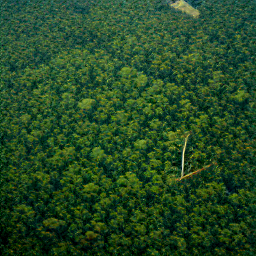

Score: 33.37




In [ ]:
for i, prompt in enumerate(prompts):
    print(f"Prompt: {prompt}\n")
    for idx in logits[i].argsort()[::-1]:
        display(images[idx * p + i])
        print(f"Score: {jnp.asarray(logits[i], dtype=jnp.float32):.2f}\n")
    print()

## 🪄 Optional: Save your Generated Images as W&B Tables

W&B Tables is an interactive 2D grid with support to rich media logging. Use this to save the generated images on W&B dashboard and share with the world.

In [ ]:
import wandb

# Initialize a W&B run.
project = 'dalle-mini-tables-colab'
run = wandb.init(project=project)

# Initialize an empty W&B Tables.
columns = ["captions"] + [f"image_{i+1}" for i in range(n_predictions)]
gen_table = wandb.Table(columns=columns)

# Add data to the table.
for i, prompt in enumerate(prompts):
    # If CLIP scores exist, sort the Images
    if logits is not None:
        idxs = logits[i].argsort()[::-1]
        tmp_imgs = images[i::len(prompts)]
        tmp_imgs = [tmp_imgs[idx] for idx in idxs]
    else:
        tmp_imgs = images[i::len(prompts)]

    # Add the data to the table.
    gen_table.add_data(prompt, *[wandb.Image(img) for img in tmp_imgs])

# Log the Table to W&B dashboard.
wandb.log({"Generated Images": gen_table})

# Close the W&B run.
run.finish()

wandb: Currently logged in as: embashosho. Use `wandb login --relogin` to force relogin


ValueError: ignored

Click on the link above to check out your generated images.